## QAOA analysis

https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20180001595.pdf

See theorem 1

$$
〈Cuv〉(d,e,f)  =1/2+1/4sin 4βsinγ(cos^dγ+cos^eγ)−1/4sin^2βcos^{(d+e−2f)}γ(1−cos^f2γ)
$$

where u, v has number of vertices d+1, e+1 with f triangles.

* analysis was taken by Hastings when f=0, d=e (d+1 - triangle-free graph)
$$
<Cuv> = 1/2( 1 + sin(4 \beta) sin(\gamma) cos^d(\gamma))
$$

Optimal value (WHY?)
$$
1/2 (1 + (1/\sqrt{d})(d/D)^{D/2})
$$

Where D is maximum vertex degree --> so for regular graphs, I guess it's $$1/2 (1 + (1/\sqrt{d})(\dfrac{d}{d+1})^{(d+1)/2})$$?

$$
1/\sqrt{d}$$ or $$ 1/\sqrt{d+1}?$$

In [281]:
def best(D):
    return ((D-1)/D)**((D-1)/2)

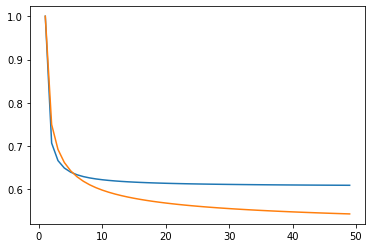

In [293]:
import matplotlib.pyplot as plt
inputs = range(1, 50)
plt.plot(inputs, [best(i) for i in inputs])
plt.plot(inputs, [0.5 + 0.5*(i**-0.5)*best(i) for i in inputs])

In [22]:
from math import log, e

In [19]:
log(2)

0.6931471805599453

In [30]:
ln

0.2567309695367395

In [36]:
def test1(n, k):
    return (1 + k/n)**n

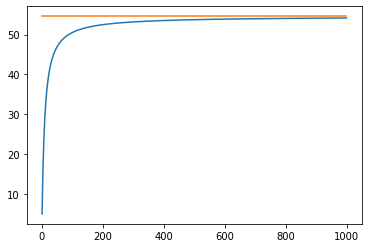

In [43]:
# test1 series converges at e^k
k=4
import matplotlib.pyplot as plt
inputs = range(1, 1000)
plt.plot(inputs, [test1(i, k) for i in inputs])
plt.plot(inputs, [e**k]*len(inputs))

In [45]:
e**-0.5

0.6065306597126334

In [50]:
log(0.6064)

-0.500215444653975

What about with triangles? but d=e

In [69]:
from numpy import sin, cos, linspace, pi
import numpy as np

In [113]:
d=20


0.2255134058981312

In [190]:
cos(np.arctan((1/10)**0.5))**10

0.6209213230591554

In [217]:
# losing precision here, I think. how do I calculate cos(x)**d without losing digits?
d=1000
gamma=np.arctan((1/d)**0.5)
# cos(gamma)
0.5 + 0.5*sin(gamma)*e**(log(cos(gamma))*d)

0.5095876953523788

In [221]:
def triangles(beta, gamma, d, f):
    return 0.5 + \
            0.5*sin(4*beta)*sin(gamma)*(cos(gamma)**d) - \
            0.25*sin(beta)*sin(beta)*(cos(gamma)**(2*d-2*f))*(1 - cos(2*gamma)**f)

In [305]:
def get_max(d, f):
    reses = []
    for beta in linspace(0, 2*pi, 128):
        res = []
        for gamma in linspace(0, 2*pi, 128):
            out = triangles(beta, gamma, d, f)
            res.append(out)
        # try optimal for triangle-free
#         res.append(triangles(beta, np.arctan((1/d)**0.5), d, f))
        reses += res
    return max(reses)


experimental idea

0.5546875

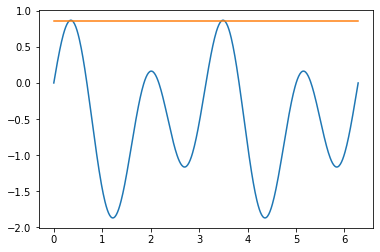

In [306]:
inputs = linspace(0, 2*pi, 512)
outs = [sin(4*i) - (sin(i)**2) for i in inputs]

plt.plot(inputs, outs)
plt.plot(inputs, [1-sin(pi/8)**2]*len(inputs))
outs.index(max(outs))/512

In [307]:
get_max(40, 0)

0.5475105835565296

In [308]:
sin(15*pi/8)**2

0.1464466094067267

vet to make sure this matches optimal for triangle-free

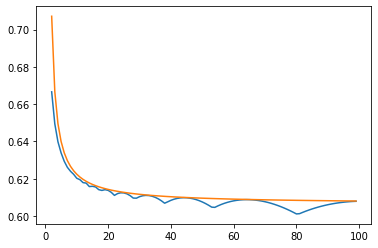

In [309]:
# should reproduce previous work by hastings and wang
# want to see how it varies with f, and see if it gets better or worse with triangles
f=0
inputs = range(2, 100)
plt.plot(inputs, [(get_max(d, f)-0.5)*2*(d+1)**0.5 for d in inputs])
plt.plot(inputs, [best(i) for i in inputs])

Gets worse with more triangles

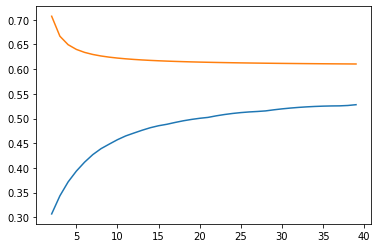

In [315]:
# should reproduce previous work by hastings and wang
# want to see how it varies with f, and see if it gets better or worse with triangles
f=10
inputs = range(2, 40)
plt.plot(inputs, [(get_max(d, f)-0.5)*2*(d+1)**0.5 for d in inputs])
plt.plot(inputs, [best(i) for i in inputs])

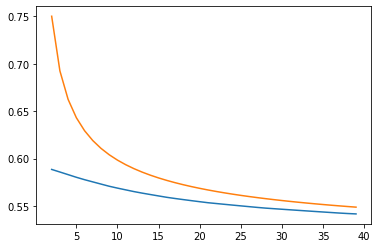

In [321]:
# should reproduce previous work by hastings and wang
# want to see how it varies with f, and see if it gets better or worse with triangles
f=10
inputs = range(2, 40)
plt.plot(inputs, [get_max(d, f) for d in inputs])
plt.plot(inputs, [0.5 + 0.5*(i**-0.5)*best(i) for i in inputs])

Could try to solve this analytically for f=1, or f=2, etc

could compare these results with hastings with triangles... each f=** value (that's how triangles works, f is number of triangles)